# Eigenvalues of a membrane
## Author: Ben Goldsberry

In [1]:
#import FEniCS module
from dolfin import *
import matplotlib.pyplot as plt
%matplotlib inline

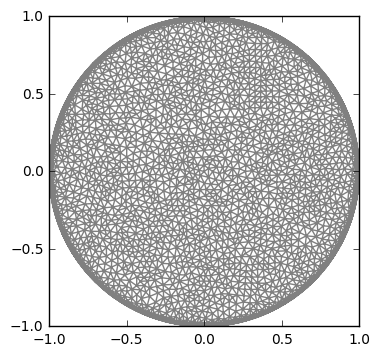

In [2]:
#Generate circle mesh using mshr module
from mshr import *
domain = Circle(Point(0, 0), 1.00,segments=1000)
mesh = generate_mesh(domain, 32)
plot(mesh)

# Vibration of a membrane
From Blackstock, the time-harmonic deflection of a membrane is described by the Helmholtz equation:
$$ \nabla^2\eta + \frac{\omega^2}{c^2}\eta = 0$$
where $c=\sqrt{T/\rho}$ is the wave speed, $T$ is the tension, and $\rho$ is the mass per area of the membrane. The weak form of the above equation is:
$$ \int \limits_\Omega \nabla \eta \cdot \nabla v d\Omega - \frac{\omega^2}{c^2}\int \limits_\Omega \eta v d\Omega - \int \limits_\Gamma v \left(\nabla \eta \cdot n\right) d\Gamma = 0$$
Since Dirichlet data is defined on the boundary of the membrane, the test function is zero inside the surface integral. For eigenvalue problems, each integral is assembled seperately. The stiffness matrix is defined as:
$$ K = \int \limits_\Omega \nabla \eta \cdot \nabla v d\Omega$$
and the mass matrix is defined as:
$$ M = \int \limits_\Omega \eta v d\Omega $$
The eigenvalue problem is then:
$$K\eta_{mn}=\lambda_{mn}^2 M\eta_{mn}$$
where $\lambda^2_{mn}=\omega_{mn}^2/c^2$ are the eigenvalues of the membrane, and $\eta_{mn}$ are the eigenmodes. From Blackstock, the eigenvalues of a membrane are
$$ \lambda_{mn}=\frac{\omega_{mn}}{c} = \frac{\alpha_{mn}}{R_0} $$
where $\alpha_{mn}$ are the roots of the Bessel function, and $R_0$ is the radius of the membrane.

# Finite element spaces
After the mesh is created or imported, the trial and test spaces are defined. We will use the continuous Galerkin method with 2nd order Lagrange elements. Mathematically, the trial and test spaces are written, respectively, as:
$$ 
\begin{align}
V &= \{v\in H^1(\Omega): v =v_D \in \Gamma\} \\
\hat{V} &= \{v\in H^1(\Omega): v=0 \in \Gamma\}
\end{align}
$$

In [3]:
V = FunctionSpace(mesh,"CG",2)
eta = TrialFunction(V)
v = TestFunction(V)

In [4]:
n = FacetNormal(mesh)
StiffnessMatrix = dot(grad(eta),grad(v))*dx
MassMatrix = eta*v*dx
lhs = Constant(0.)*dot(grad(v),n)*ds

# Dirichlet (Essential) boundary conditions
Dirichlet boundary conditions are essential conditions, meaning that the function values at the boundary nodes are constrained. This is enforced by direct manipulation of the mass and stiffness matrices at assembly. To enforce essential boundary conditions in FEniCS, a function must first be created that defines the boundary. The FEniCS function DirichletBC() then calls the boundary function and constrains the nodes by the value provided.

In [5]:
def boundary(x, on_boundary):
    return on_boundary
u_D = Constant(0.)
bc = DirichletBC(V, u_D, boundary)

# Eigenvalue solver
We will use the package SLEPC (Scalable Library for Eigenvalue Problem Computations) to compute the eigenvalues. First, the mass and stiffness matrices are assembled as PETSc matrices. 

In [6]:
K = PETScMatrix()
M = PETScMatrix()
assemble_system(StiffnessMatrix,lhs,bc,A_tensor=K)
assemble_system(MassMatrix,lhs,bc,A_tensor=M)

(<dolfin.cpp.la.PETScMatrix; proxy of <Swig Object of type 'std::shared_ptr< dolfin::PETScMatrix > *' at 0x7f37bbafbcf0> >,
 <dolfin.cpp.la.Vector; proxy of <Swig Object of type 'std::shared_ptr< dolfin::Vector > *' at 0x7f37bbafbed0> >)

In [7]:
NEigs = 10 #Solve for the first N eigenvalues
eigensolver = SLEPcEigenSolver(K,M) #Create eigensolver
#Important!: Must apply spectral transform to calculate lowest eigenvalues
eigensolver.parameters["spectral_transform"]="shift-and-invert"
eigensolver.parameters["spectral_shift"]=5.0
eigensolver.parameters["problem_type"] = "gen_hermitian"

In [8]:
eigensolver.solve(NEigs)
Nconverged=eigensolver.get_number_converged()
print(str(Nconverged) + ' out of ' + str(NEigs) + ' converged.')

10 out of 10 converged.


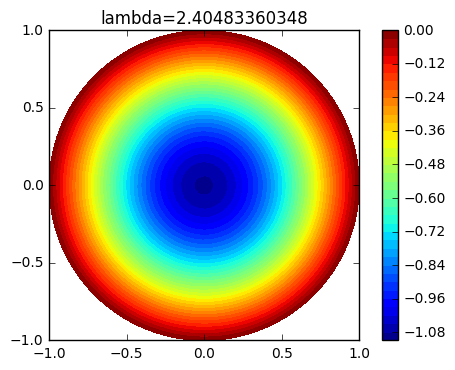

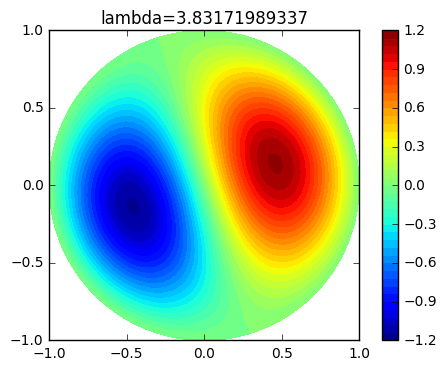

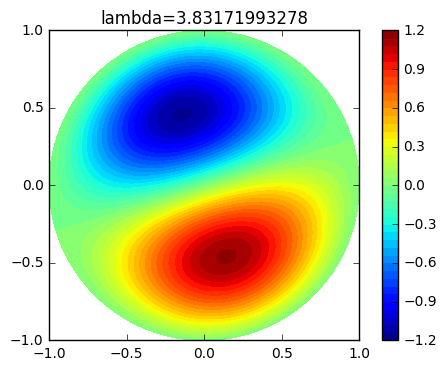

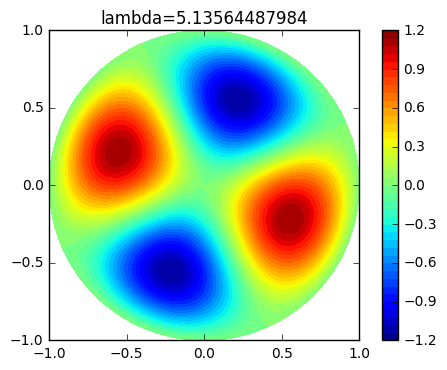

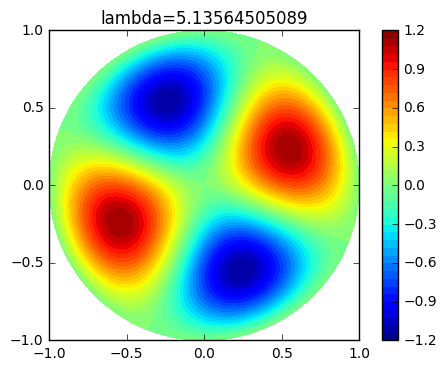

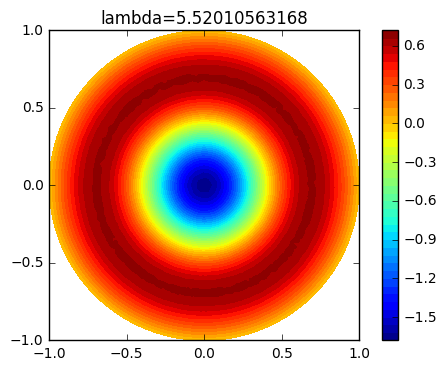

In [9]:
#Extract eigenvalues and eigenvectors and plot
import numpy as np

for ii in range(NEigs):
    eigValR,eigValI,eigVecR,eigVecI = eigensolver.get_eigenpair(ii)
    eigVec = Function(V)
    eigVec.vector()[:] = np.ascontiguousarray(eigVecR)
    if np.sqrt(eigValR) > 1.1:
        #print('EigValR = ' + str(np.sqrt(eigValR)) + ', eigValI = ' + str(eigValI))
        plt.figure()
        qr=plot(eigVec,title='lambda='+str(np.sqrt(eigValR)))
        plt.colorbar(qr)
        plt.show()
    